# Preliminary preparation

## Directory
Setting up the project and dataset directories

In [12]:
# Set root dir
import os

os.chdir("/")
print("Current Working Directory:", os.getcwd())

# !!CHANGE THIS!!
working_dir="/BigData"
dataset_dir=f"{working_dir}/dataset"

dataset_original_csv = f'{dataset_dir}/creditScores.csv'

dataset_csv_path = f'{dataset_dir}/creditScores_csv'
dataset_json_path = f'{dataset_dir}/creditScores_json'
dataset_parquet_path = f'{dataset_dir}/creditScores_parquet'
dataset_orc_path = f'{dataset_dir}/creditScores_orc'
dataset_avro_path = f'{dataset_dir}/creditScores_avro'

clean_dataset_path = f'{dataset_dir}/clean_creditScores_orc'

os.chdir(working_dir)
print(f"New working directory: {working_dir}")


Current Working Directory: /
New working directory: /BigData


## Spark Session

In [13]:
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .appName("projBigData_dataExploration")\
        .getOrCreate()

## Import Libraries

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pyspark.sql.functions as F
from pyspark.sql.functions import *
import numpy as np
from pyspark.sql.types import *
from pyspark.ml.feature import Bucketizer

# Pre-Process
Reading the dataset csv into a spark DataFrame

In [15]:
df = spark.read.orc(clean_dataset_path)
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Customer_ID: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SSN: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Annual_Income: float (nullable = true)
 |-- Monthly_Inhand_Salary: float (nullable = true)
 |-- Num_Bank_Accounts: integer (nullable = true)
 |-- Num_Credit_Card: integer (nullable = true)
 |-- Interest_Rate: float (nullable = true)
 |-- Num_of_Loan: integer (nullable = true)
 |-- Type_of_Loan: string (nullable = true)
 |-- Delay_from_due_date: integer (nullable = true)
 |-- Num_of_Delayed_Payment: float (nullable = true)
 |-- Changed_Credit_Limit: float (nullable = true)
 |-- Num_Credit_Inquiries: integer (nullable = true)
 |-- Credit_Mix: string (nullable = true)
 |-- Outstanding_Debt: float (nullable = true)
 |-- Credit_Utilization_Ratio: float (nullable = true)
 |-- Credit_History_Age: integer (nullable = true)


In [16]:
df.orderBy("Customer_ID").show()

+-----+-----------+--------+-----------------+----+-----------+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------+---------------+------------+
|   ID|Customer_ID|   Month|             Name| Age|        SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|Monthly_Balance|Credit_Score|
+-----+-----------+--------+-----------------+----+-----------+-------

In [17]:
df.show()

+------+-----------+--------+--------------------+----+-----------+-------------+-------------+---------------------+-----------------+---------------+-------------+-----------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------+---------------+------------+
|    ID|Customer_ID|   Month|                Name| Age|        SSN|   Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|Monthly_Balance|Credit_Score|
+------+-----------+--------+--------------------+----+-

# Data Exploration

Data Dictionary

| Nome Campo               | Descrição                                                | Tipo de Dados           |
|--------------------------|----------------------------------------------------------|-------------------------|
|ID|Identificação exluciva do registo|Numérico (hexadecimal)|
|Customer_ID|Identificação exluciva do cliente|Texto (string + hexadecimal)|
|Month|Mês do ano|Texto (string)|
|Name|Nome da pessoa|Texto (string)|
|Age|Idade da pessoa|Numérico (inteiro)|
|SSN|Número da segurança social da pessoa|Numérico (inteiro)|
|Occupation|Ocupação da pessoa|Texto (string)|
|Annual_Income|Rendimento anual da pessoa|Numérico (float)|
|Monthly_Inhand_Salary|Salário base mensal da pessoa|Numérico (float)|
|Num_Bank_Accounts|Número de contas bancárias da pessoa|Numérico (inteiro)|
|Num_Credit_Card|Número de cartões de crédito que a pessoa possui|Numérico (inteiro)|
|Interest_Rate|Taxa de juro no cartão de crédito da pessoa|Numérico (inteiro)|
|Num_of_Loan|Número de empréstimos contraídos junto do banco|Numérico (inteiro)|
|Type_of_Loan|Tipos de empréstimo contraído pela pessoa|Texto (string)|
|Delay_from_due_date|Número médio de dias de atraso a partir da data de pagamento|Numérico (inteiro)|
|Num_of_Delayed_Payment|Número de pagamentos atrasados pela pessoa|Numérico (inteiro)|
|Changed_Credit_Limit|Variação percentual no limite do cartão de crédito|Numérico (float)|
|Num_Credit_Inquiries|Número de consultas de cartão de crédito pela pessoa|Numérico (float)|
|Credit_Mix|Classificação da mistura de créditos|Texto (string)|
|Outstanding_Debt|A dívida restante a ser paga (em USD)|Numérico (float)|
|Credit_Utilization_Ratio|O rácio de utilização do cartão de crédito do cliente|Numérico (float)|
|Credit_History_Age|A idade do histórico de crédito da pessoa|Texto (string)|
|Credit_History_Age_Months|A idade do histórico de crédito da pessoa em meses (Coluna calculada)|Numérico (inteiro)|
|Payment_of_Min_Amount|Representa se o montante mínimo foi pago pela pessoa (“No”,”Yes”, “NM”)|Texto (string)|
|Total_EMI_per_month|Pagamentos mensais do EMI (Equated Monthly Installment (prestação mensal equilibrada)) (em USD)|Numérico (float)|
|Amount_invested_monthly|Montante mensal investido pelo cliente (em USD)|Numérico (float)|
|Payment_Behaviour|Comportamento de pagamento do cliente (em USD)|Texto (string)|
|Monthly_Balance|Montante do saldo mensal do cliente (em USD)|Numérico (float)|
|Credit_Score|Pontuação do crédito da pessoa. Pode assumir um dos seguintes valores: “Good”, “Standard” ou “Poor”, conforme a pontuação do crédito|Texto (string)|


In [18]:
df.describe().show()

+-------+-----------------+------------------+------+------+------------------+-----------+----------+-----------------+---------------------+------------------+-----------------+-----------------+-----------------+--------------------+-------------------+----------------------+--------------------+--------------------+----------+------------------+------------------------+------------------+---------------------+-------------------+-----------------------+--------------------+------------------+------------+
|summary|               ID|       Customer_ID| Month|  Name|               Age|        SSN|Occupation|    Annual_Income|Monthly_Inhand_Salary| Num_Bank_Accounts|  Num_Credit_Card|    Interest_Rate|      Num_of_Loan|        Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|  Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|   Payment_Behaviour|   

### Missing Values

In [19]:
#Check Missing Values
def check_missing(dataframe):
    
    return dataframe.select([count(when(col(c).isNull() , c)). \
                             alias(c) for c in dataframe.columns]).show()

check_missing(df)

+---+-----------+-----+----+----+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+------------+-------------------+----------------------+--------------------+--------------------+----------+----------------+------------------------+------------------+---------------------+-------------------+-----------------------+-----------------+---------------+------------+
| ID|Customer_ID|Month|Name| Age|SSN|Occupation|Annual_Income|Monthly_Inhand_Salary|Num_Bank_Accounts|Num_Credit_Card|Interest_Rate|Num_of_Loan|Type_of_Loan|Delay_from_due_date|Num_of_Delayed_Payment|Changed_Credit_Limit|Num_Credit_Inquiries|Credit_Mix|Outstanding_Debt|Credit_Utilization_Ratio|Credit_History_Age|Payment_of_Min_Amount|Total_EMI_per_month|Amount_invested_monthly|Payment_Behaviour|Monthly_Balance|Credit_Score|
+---+-----------+-----+----+----+---+----------+-------------+---------------------+-----------------+---------------+-------------+-----------+

/tmp/ipykernel_23520/3095855501.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_yticklabels(y_labels)


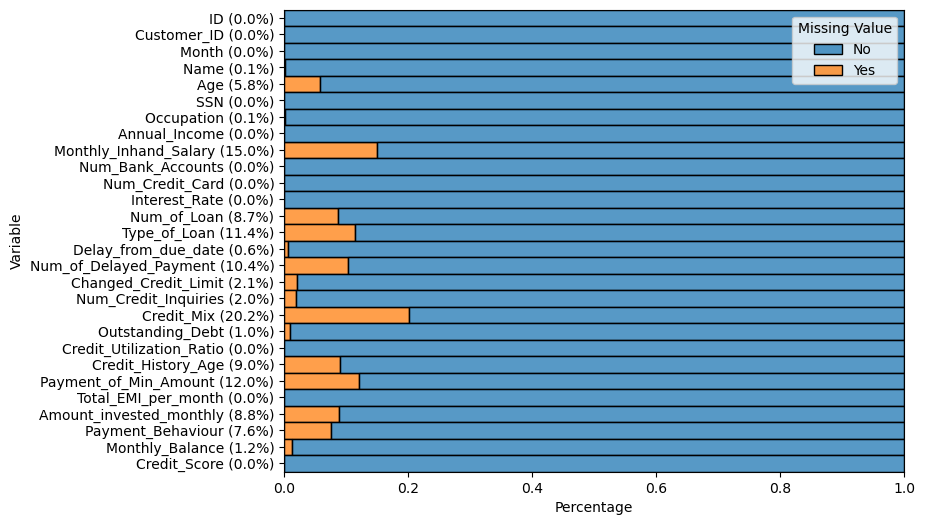

[0.0, 0.0, 0.0, 0.00128, 0.05825, 0.0, 0.0008, 0.00034, 0.15002, 0.00021, 0.0, 0.0, 0.08661, 0.11408, 0.00591, 0.10368, 0.02091, 0.01965, 0.20195, 0.01009, 0.0, 0.0903, 0.12007, 0.0, 0.08784, 0.076, 0.01209, 0.0]


In [20]:
def na_ratio_plot(df):
    columns = df.columns

    missing_ratios = [
        (df.filter(F.col(column).isNull() | (F.col(column) == "")).count() / df.count())
        for column in columns
    ]

    plot_df = df.select(*[F.when(F.col(column).isNull() | (F.col(column) == ""), True).otherwise(False).alias(column) for column in columns]).toPandas()
    plot_df = plot_df.melt(value_name='Missing Value', var_name='Variable')
    plot_df['Missing Value'] = plot_df['Missing Value'].map({True: 'Yes', False: 'No'})

    plt.figure(figsize=(8, 6))
    plot = sns.histplot(plot_df, y='Variable', hue='Missing Value', multiple='fill', stat='probability', element='bars')

    y_labels = plot.get_yticklabels()
    # Add percentage to the y label
    for label, missing_ratio in zip(y_labels, missing_ratios):
        feature = label.get_text()
        label.set_text(f'{feature} ({missing_ratio*100:.1f}%)')

    plot.set_yticklabels(y_labels)
    plot.set_xlabel('Percentage')

    plt.show()
    print(missing_ratios)

na_ratio_plot(df)

### Duplicates

In [21]:
duplicates_count = df.groupBy(df.columns).count().where(F.col('count') > 1).count()

if duplicates_count == 0:
    print("No duplicate rows in the dataset")
else:
    print(f"There are {duplicates_count} duplicated rows")  

No duplicate rows in the dataset


### Outliers

In [49]:
num_features = _df.select_dtypes(include=[np.number]).columns.tolist()

# Remove "ID" and "Customer_ID"
num_features.remove("ID")
num_features.remove("Customer_ID")

def count_outliers_iqr(dataframe, factor=1.5):
    print("\nOutlier Counts:")
    print(f"Factor: {factor}")
    
    # Iterate through numeric columns
    for column in num_features:
        field_type = dataframe.schema[column].dataType
        
        # Calculate quartiles and IQR
        q1, q3 = dataframe.approxQuantile(column, [0.25, 0.75], 0.01)
        iqr = q3 - q1
        
        # Calculate lower and upper bounds for outliers
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr
        
        outlier_count = dataframe.filter((F.col(column) < lower_bound) | (F.col(column) > upper_bound)).count()
        
        print(f"{column}: {outlier_count} outliers")

# Call count_outliers_iqr with default and custom factors
count_outliers_iqr(df)
count_outliers_iqr(df, 3)


Outlier Counts:
Factor: 1.5
Age: 1810 outliers
Annual_Income: 2218 outliers
Monthly_Inhand_Salary: 1911 outliers
Num_Bank_Accounts: 1315 outliers
Num_Credit_Card: 2271 outliers
Interest_Rate: 2034 outliers
Num_of_Loan: 447 outliers
Delay_from_due_date: 4002 outliers
Num_of_Delayed_Payment: 717 outliers
Changed_Credit_Limit: 1127 outliers
Num_Credit_Inquiries: 1650 outliers
Outstanding_Debt: 5887 outliers
Credit_Utilization_Ratio: 5 outliers
Credit_History_Age: 0 outliers
Total_EMI_per_month: 7286 outliers
Amount_invested_monthly: 7925 outliers
Monthly_Balance: 8095 outliers

Outlier Counts:
Factor: 3
Age: 1810 outliers
Annual_Income: 2 outliers
Monthly_Inhand_Salary: 0 outliers
Num_Bank_Accounts: 1314 outliers
Num_Credit_Card: 2266 outliers
Interest_Rate: 2033 outliers
Num_of_Loan: 447 outliers
Delay_from_due_date: 0 outliers
Num_of_Delayed_Payment: 717 outliers
Changed_Credit_Limit: 0 outliers
Num_Credit_Inquiries: 1649 outliers
Outstanding_Debt: 0 outliers
Credit_Utilization_Ratio: 

A lot of outlier situations found in the dataset are extreme cases, when adjusting the outlier factor the number of outliers barely changes.

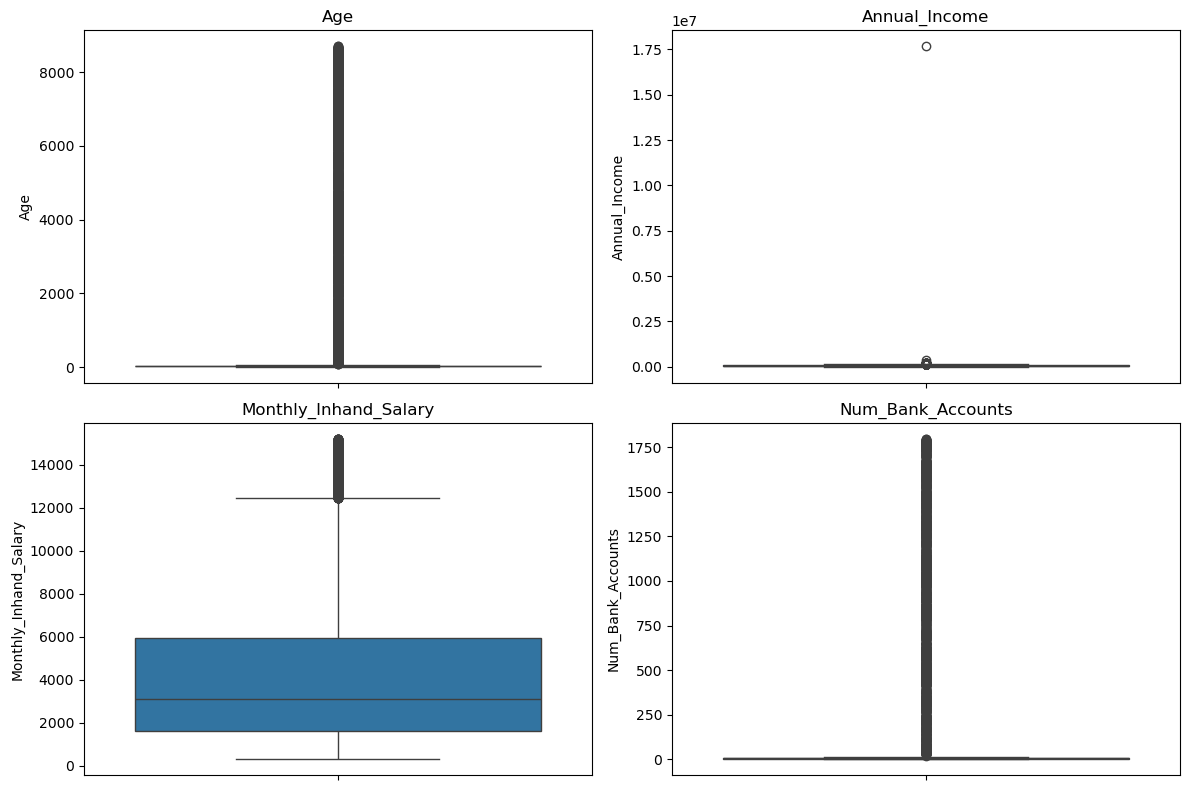

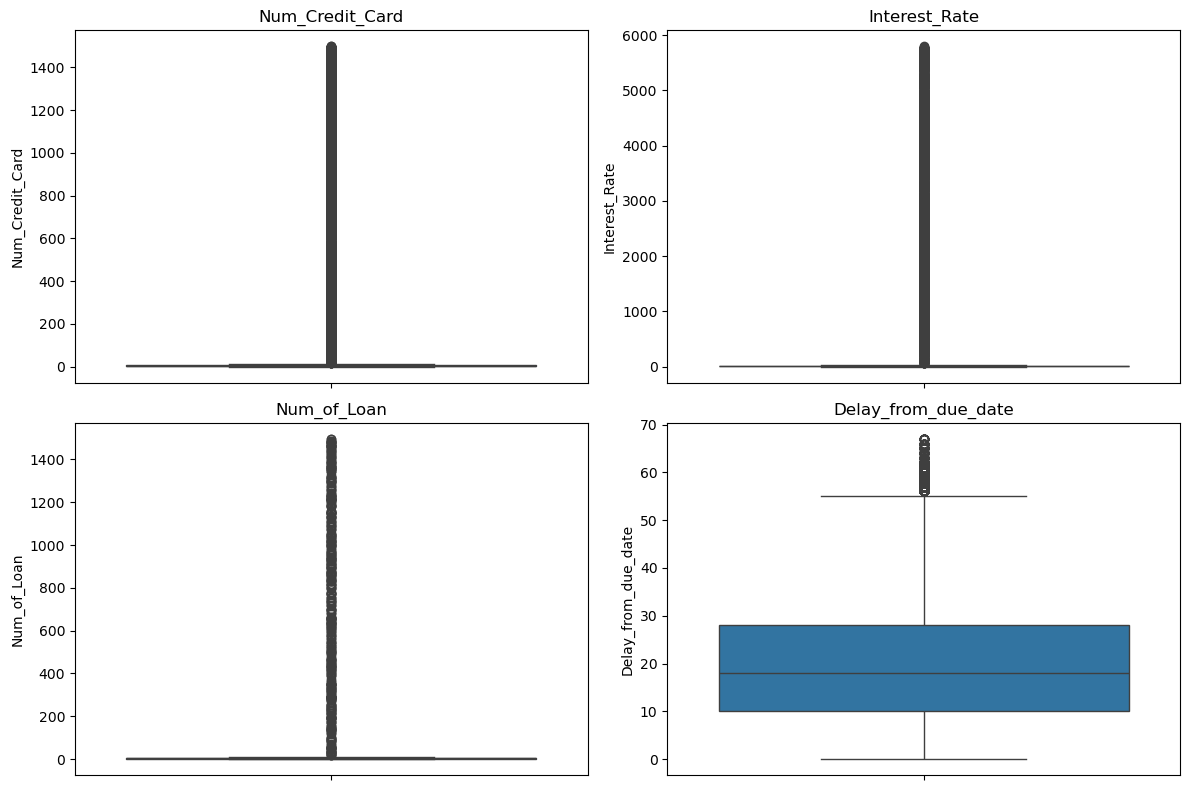

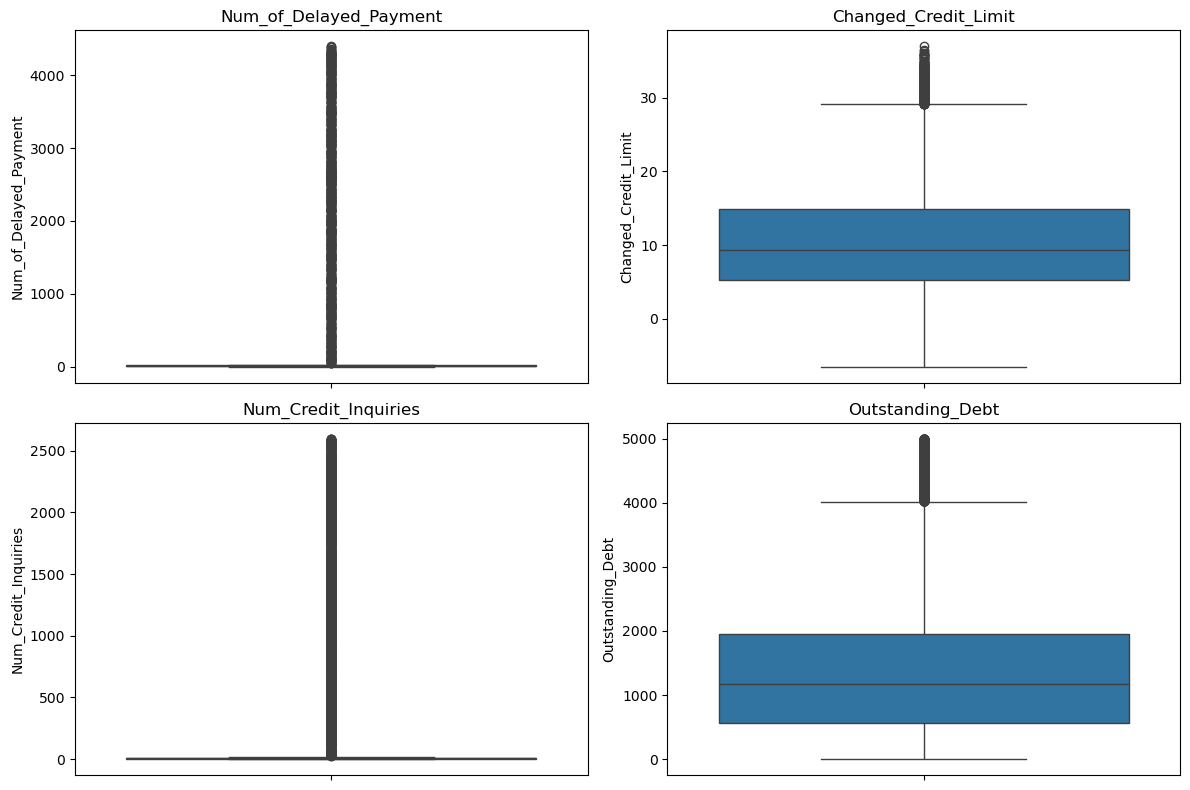

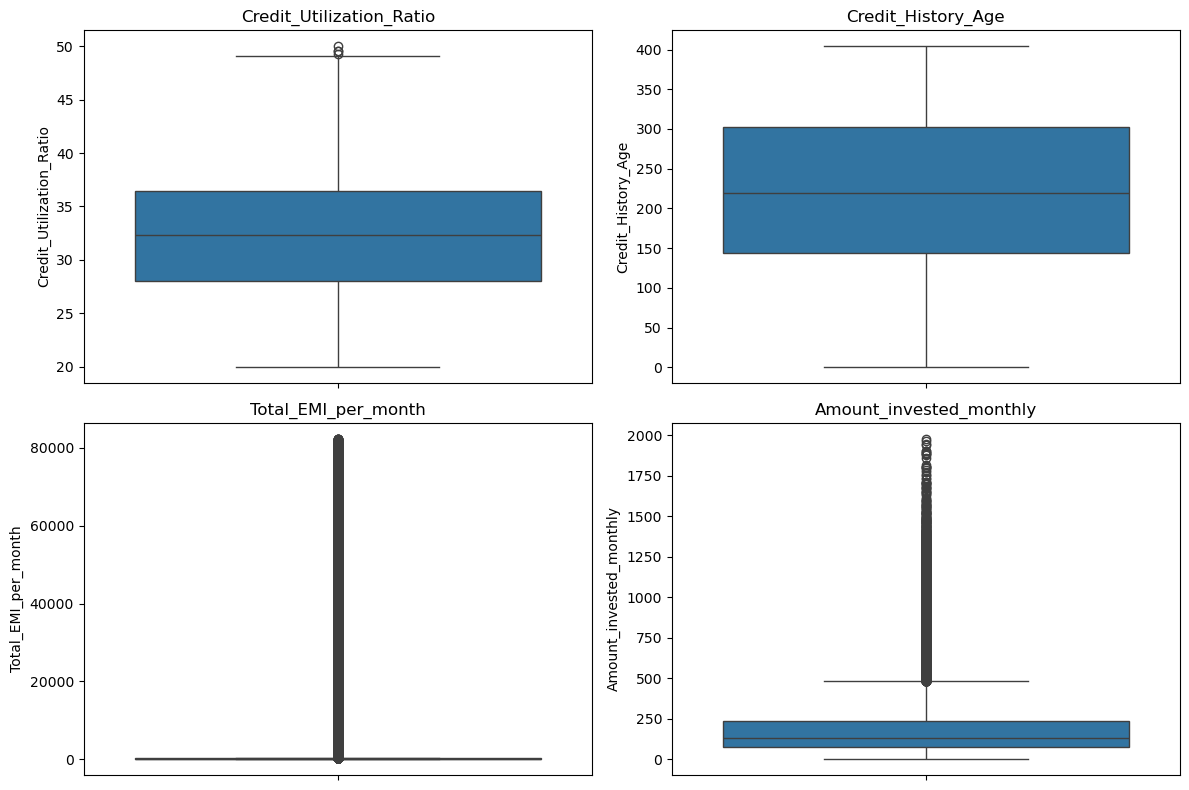

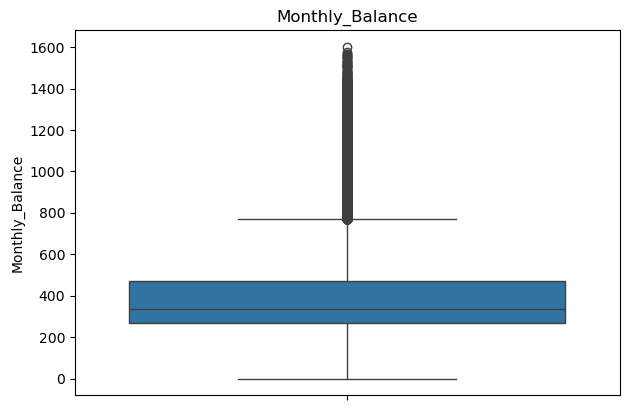

In [47]:
num_batches = len(num_features) // 4 + (len(num_features) % 4 > 0)  # Calculate the number of 4x4 frames

for i in range(num_batches):
    batch_features = num_features[i * 4: (i + 1) * 4]  # Select 4 features for each batch

    plt.figure(figsize=(12, 8))

    for j, feature in enumerate(batch_features):
        plt.subplot(2, 2, j + 1)
        sns.boxplot(y=_df[feature])
        plt.title(feature)

    plt.tight_layout()
    plt.show()

### Age

In [23]:
df.describe('Age').show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|             94175|
|   mean|116.68218741704274|
| stddev| 690.0798450131382|
|    min|                14|
|    max|              8698|
+-------+------------------+



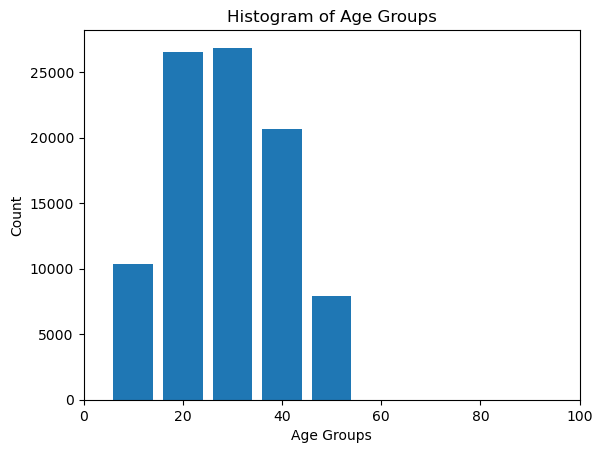

In [24]:
# From the previous table, we find that the max age is 8698, as this value can't be real, and the same situation applies for
# many other values within column Age we decided to restrict the graphing to feasible age range

df_age_group = df.withColumn('Age_Group', floor(df['Age'] / 10) * 10)

df_for_plot = df_age_group.filter(df_age_group['Age_Group'].isNotNull())
df_for_plot = df_for_plot.groupBy('Age_Group').agg({'Age': 'count'}).orderBy('Age_Group').collect()

# Extracting data for plotting
age_groups = [int(row['Age_Group']) for row in df_for_plot]
counts = [row['count(Age)'] for row in df_for_plot]

plt.bar(age_groups, counts, width=8.0)
plt.xlabel('Age Groups')
plt.ylabel('Count')
plt.title('Histogram of Age Groups')
plt.xlim(0, 100)  # Set x-axis limit to keep it between 0 and 100
plt.show()

### Occupation

In [25]:
# Grouping by 'Occupation' and counting occurrences
occupation_count = df.groupBy('Occupation').count().orderBy('count', ascending=True)
occupation_count.show()

+-------------+-----+
|   Occupation|count|
+-------------+-----+
|             |   80|
|       Writer| 6304|
|     Musician| 6352|
|      Manager| 6424|
|   Journalist| 6536|
|       Doctor| 6552|
| Entrepreneur| 6648|
|      Teacher| 6664|
|Media_Manager| 6704|
|    Developer| 6720|
|    Scientist| 6744|
|   Accountant| 6744|
|     Mechanic| 6776|
|    Architect| 6816|
|     Engineer| 6840|
|       Lawyer| 7096|
+-------------+-----+



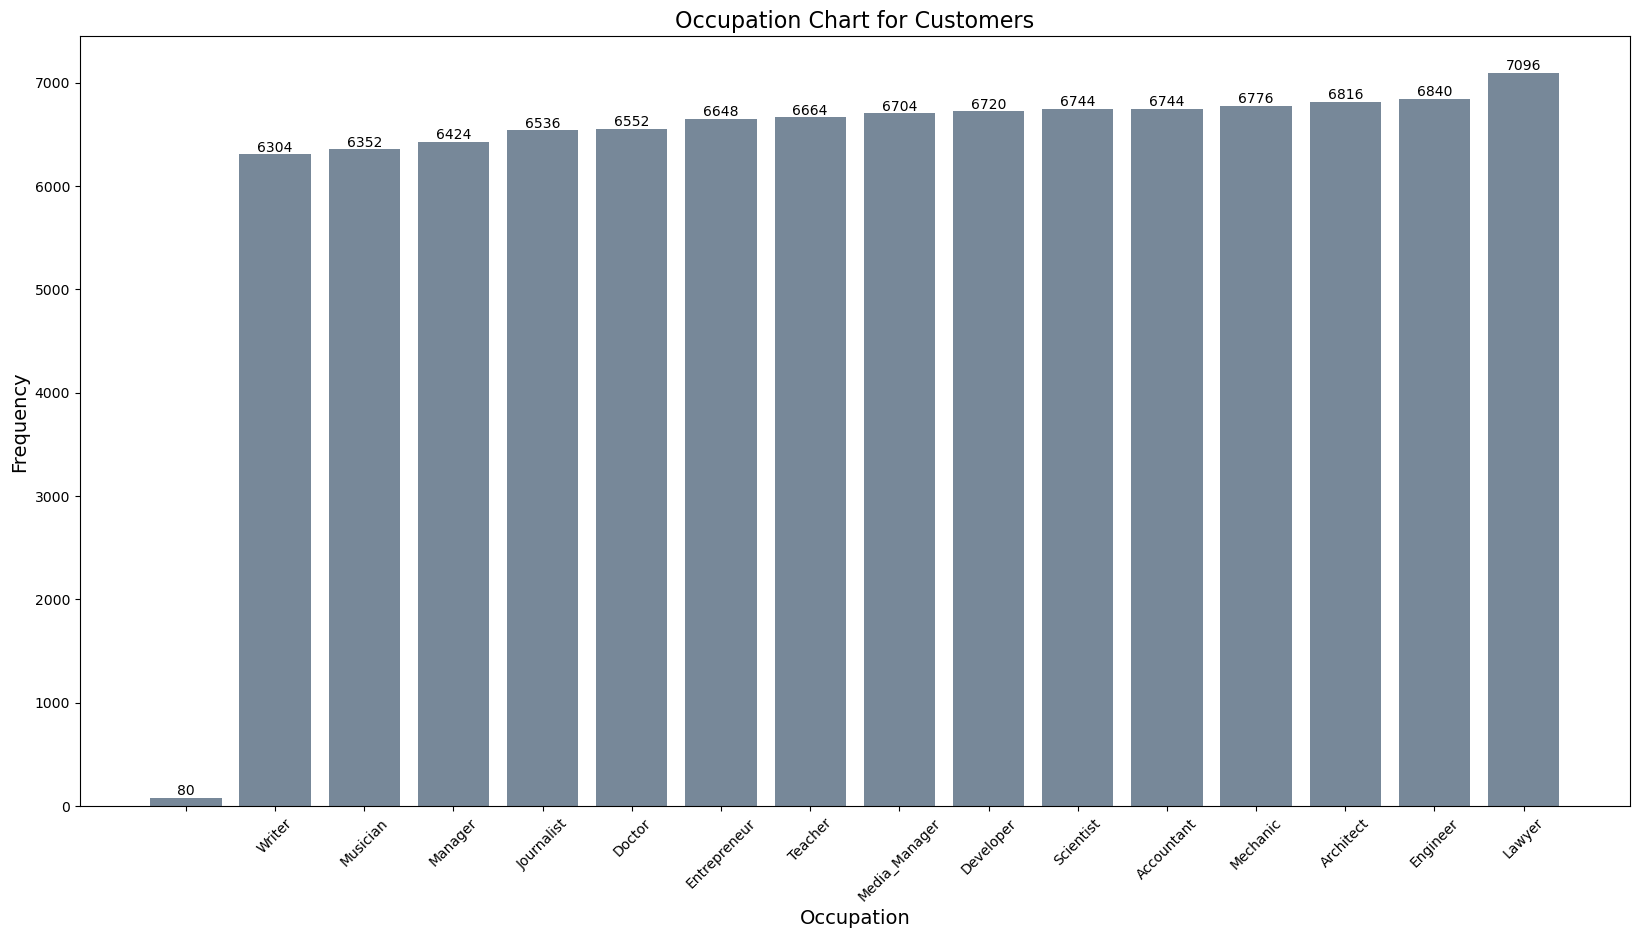

In [26]:
pd_occupation_count = occupation_count.toPandas()

plt.figure(figsize=(20, 10))
bars = plt.bar(pd_occupation_count["Occupation"], pd_occupation_count["count"], color="#778899")

# Add the count values above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        str(height),
        ha="center",
        va="bottom",
    )

plt.title("Occupation Chart for Customers", fontsize=16)
plt.ylabel("Frequency", fontsize=14)
plt.xlabel("Occupation", fontsize=14)
plt.xticks(rotation=45)
plt.show()

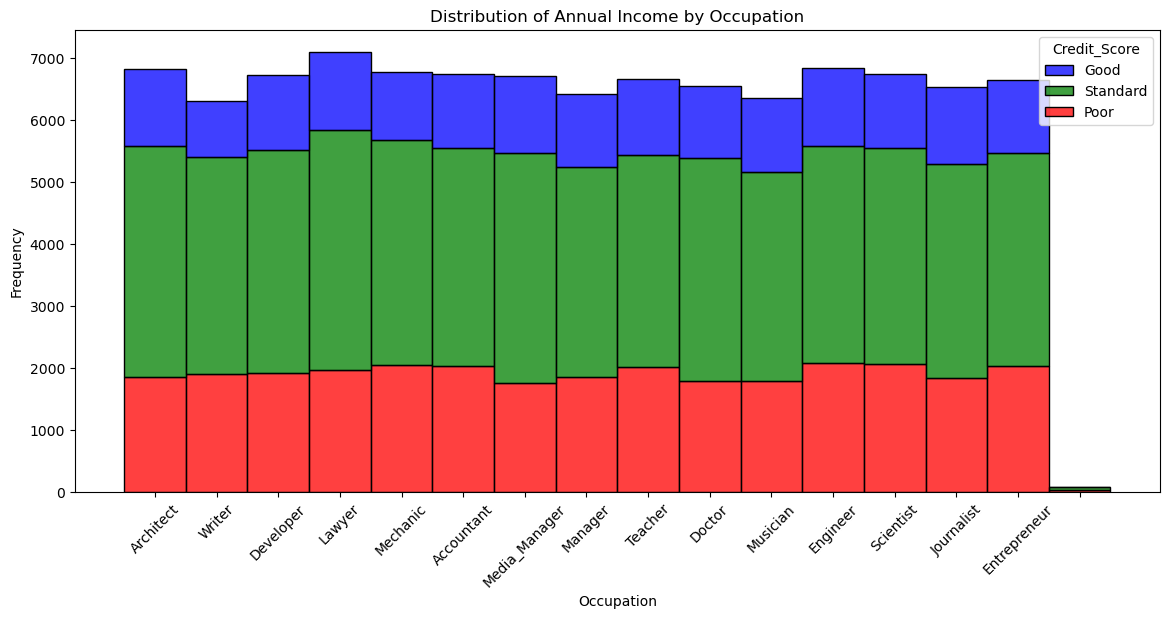

In [27]:
palette = {"Good": "blue", "Standard": "green", "Poor": "red"}

# Plot the histogram with Occupation on the x-axis
plt.figure(figsize=(14, 6))
sns.histplot(data=df.toPandas(), x="Occupation", hue="Credit_Score", multiple="stack", palette=palette, binwidth=1.0)
plt.xlabel('Occupation')
plt.ylabel('Frequency')
plt.title('Distribution of Annual Income by Occupation')
plt.xticks(rotation=45)
plt.show()

### Annual Income

In [28]:
df.describe('Annual_Income') \
  .select('summary', format_number(col('Annual_Income').cast('double'), 0).alias('Formatted_Annual_Income')) \
  .show()

+-------+-----------------------+
|summary|Formatted_Annual_Income|
+-------+-----------------------+
|  count|                 99,966|
|   mean|                 50,694|
| stddev|                 67,625|
|    min|                  7,006|
|    max|             17,668,708|
+-------+-----------------------+



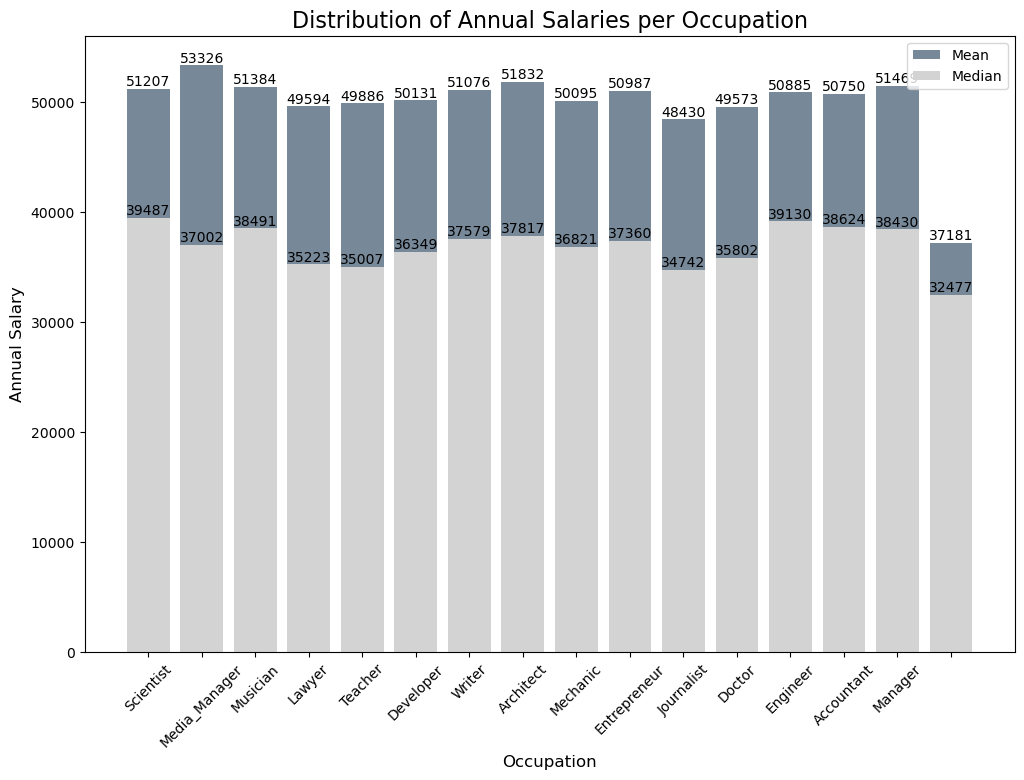

In [29]:
mean_income_pandas = df.groupBy('Occupation').agg(mean('Annual_Income').alias('Mean_Income')).toPandas()
median_income_pandas = df.groupBy('Occupation').agg(median('Annual_Income').alias('Median_Income')).toPandas()

color = '#778899'

plt.figure(figsize=(12, 8))
plt.bar(mean_income_pandas['Occupation'], mean_income_pandas['Mean_Income'], color=color, label='Mean')
plt.bar(median_income_pandas['Occupation'], median_income_pandas['Median_Income'], color='lightgray', label='Median')

# Add rounded values above each bar for mean
for i, v in enumerate(mean_income_pandas['Mean_Income']):
    plt.text(i, v, f"{int(v)}", ha='center', va='bottom', fontsize=10)

# Add rounded values above each bar for median
for i, v in enumerate(median_income_pandas['Median_Income']):
    plt.text(i, v, f"{int(v)}", ha='center', va='bottom', fontsize=10, color='black')

plt.xticks(rotation=45)
plt.title("Distribution of Annual Salaries per Occupation", fontsize=16)
plt.xlabel("Occupation", fontsize=12)
plt.ylabel("Annual Salary", fontsize=12)
plt.legend()

plt.show()

In [52]:
df.describe("Annual_Income").show()

+-------+-----------------+
|summary|    Annual_Income|
+-------+-----------------+
|  count|            99966|
|   mean|50694.29548333543|
| stddev|67625.07310596404|
|    min| 7005.93017578125|
|    max|      1.7668708E7|
+-------+-----------------+



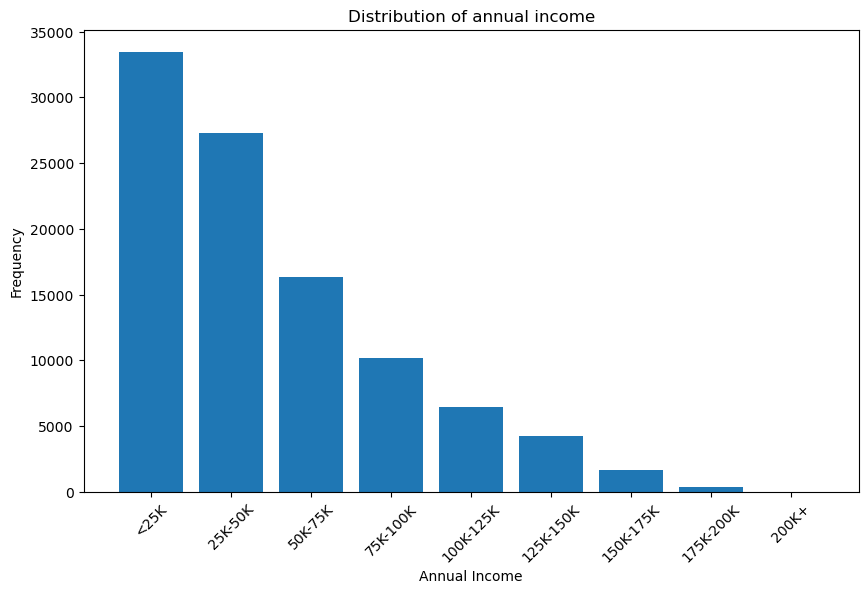

In [31]:
# Convert 'Annual_Income' to numeric type
df = df.withColumn('Annual_Income', F.col('Annual_Income').cast('double'))

# Define bins and labels
bins = [0, 25000, 50000, 75000, 100000, 125000, 150000, 175000, 200000, float('inf')]
labels = ['<25K', '25K-50K', '50K-75K', '75K-100K', '100K-125K', '125K-150K', '150K-175K', '175K-200K', '200K+']

# Create Bucketizer
bucketizer = Bucketizer(splits=bins, inputCol="Annual_Income", outputCol="Income_Range")
df_bucketizer = bucketizer.transform(df)

income_range_counts = df_bucketizer.groupBy('Income_Range').agg(F.count('*').alias('Frequency')).sort('Income_Range')

# Filter out rows where 'Income_Range' is None
income_range_data = income_range_counts.filter(income_range_counts["Income_Range"].isNotNull()).collect()

# Extract collected data for plotting
x_labels = [labels[int(row['Income_Range'])] for row in income_range_data if row['Income_Range'] is not None]
y_values = [row['Frequency'] for row in income_range_data if row['Income_Range'] is not None]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(x_labels, y_values)
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.title('Distribution of annual income')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility if needed
plt.show()


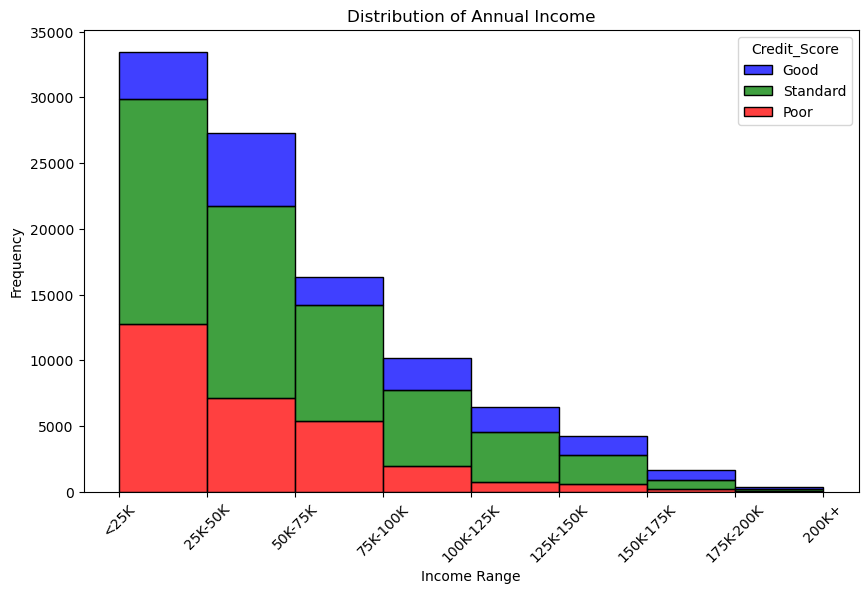

In [32]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_bucketizer.toPandas(), x="Income_Range", hue="Credit_Score", multiple="stack", palette=palette, binwidth=1.0)
plt.xlabel('Income Range')
plt.ylabel('Frequency')
plt.title('Distribution of Annual Income')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)

plt.show()

### Monthly Income

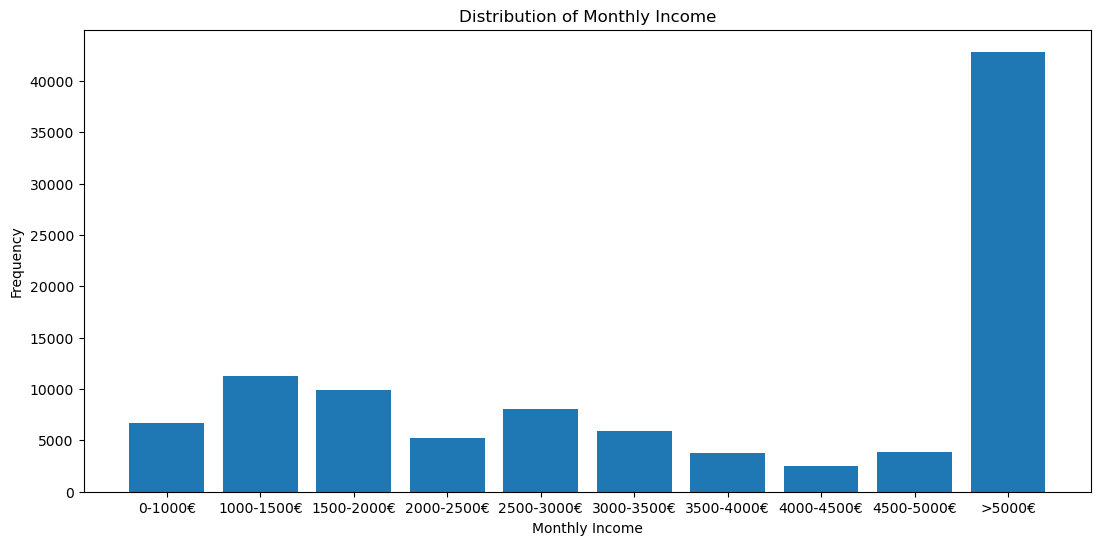

In [33]:
# Create a new column for income range
df = df.withColumn('Monthly_Range',  F.when((F.col('Monthly_Inhand_Salary') >= 0) & (F.col('Monthly_Inhand_Salary') < 1000), '0-1000€')
                                    .when((F.col('Monthly_Inhand_Salary') >= 1000) & (F.col('Monthly_Inhand_Salary') < 1500), '1000-1500€')
                                    .when((F.col('Monthly_Inhand_Salary') >= 1500) & (F.col('Monthly_Inhand_Salary') < 2000), '1500-2000€')
                                    .when((F.col('Monthly_Inhand_Salary') >= 2000) & (F.col('Monthly_Inhand_Salary') < 2500), '2000-2500€')
                                    .when((F.col('Monthly_Inhand_Salary') >= 2500) & (F.col('Monthly_Inhand_Salary') < 3000), '2500-3000€')
                                    .when((F.col('Monthly_Inhand_Salary') >= 3000) & (F.col('Monthly_Inhand_Salary') < 3500), '3000-3500€')
                                    .when((F.col('Monthly_Inhand_Salary') >= 3500) & (F.col('Monthly_Inhand_Salary') < 4000), '3500-4000€')
                                    .when((F.col('Monthly_Inhand_Salary') >= 4000) & (F.col('Monthly_Inhand_Salary') < 4500), '4000-4500€')
                                    .when((F.col('Monthly_Inhand_Salary') >= 4500) & (F.col('Monthly_Inhand_Salary') < 5000), '4500-5000€')
                                    .otherwise('>5000€'))

income_range_pandas = df.groupBy('Monthly_Range').count().orderBy('Monthly_Range').toPandas()

plt.figure(figsize=(13, 6))
plt.bar(income_range_pandas['Monthly_Range'], income_range_pandas['count'])
plt.xlabel('Monthly Income')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Income')
plt.show()

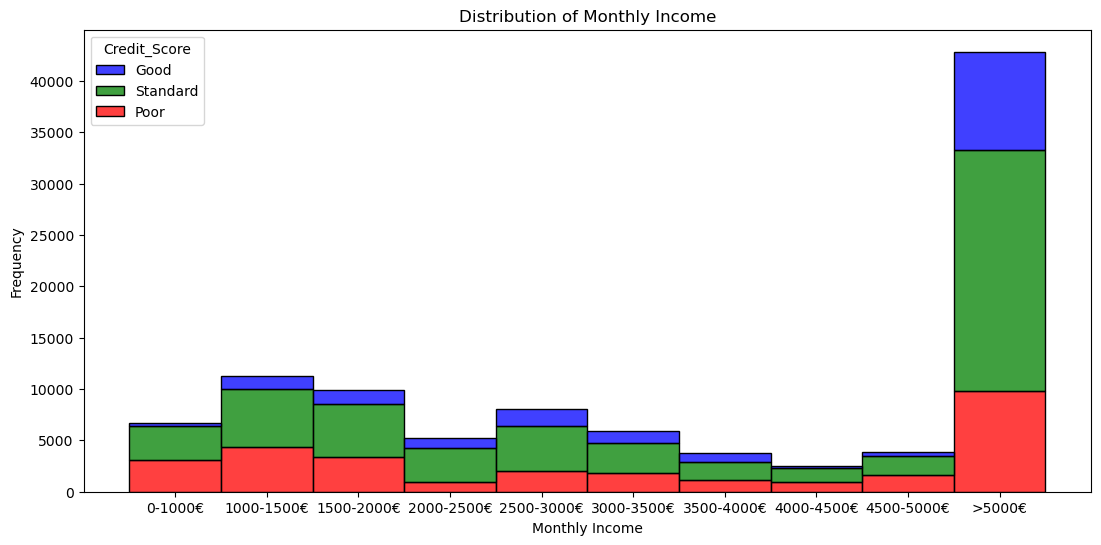

In [34]:
_df=df.orderBy('Monthly_Inhand_Salary').toPandas()

income_range_order = ['0-1000€', '1000-1500€', '1500-2000€', '2000-2500€', '2500-3000€', '3000-3500€', '3500-4000€', '4000-4500€', '4500-5000€', '>5000€']
_df['Monthly_Range'] = _df['Monthly_Range'].astype('category')
_df['Monthly_Range'] = _df['Monthly_Range'].cat.reorder_categories(income_range_order, ordered=True)


plt.figure(figsize=(13, 6))
sns.histplot(data=_df, x="Monthly_Range", hue="Credit_Score", multiple="stack", palette=palette)
plt.xlabel('Monthly Income')
plt.ylabel('Frequency')
plt.title('Distribution of Monthly Income')
plt.show()

### Credit Mix

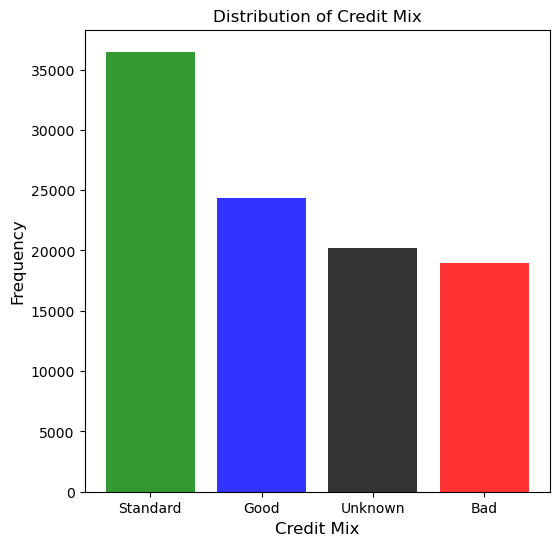

In [35]:
credit_mix_count = df.fillna("Unknown").groupBy('Credit_Mix').count().collect()
# Sort the data by count in descending order
credit_mix_count.sort(key=lambda x: x['count'], reverse=True)

categories = [row['Credit_Mix'] if row['Credit_Mix'] else 'Unknown' for row in credit_mix_count]
values = [row['count'] for row in credit_mix_count]

palette_c_mix = {"Bad": "red", "Standard": "green", "Good": "blue", "Unknown": "black"}

plt.figure(figsize=(6, 6))
bars = plt.bar(categories, values, alpha=0.8, color=[palette_c_mix[cat] for cat in categories])
plt.title('Distribution of Credit Mix')
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Credit Mix', fontsize=12)
plt.show()

### Credit Score

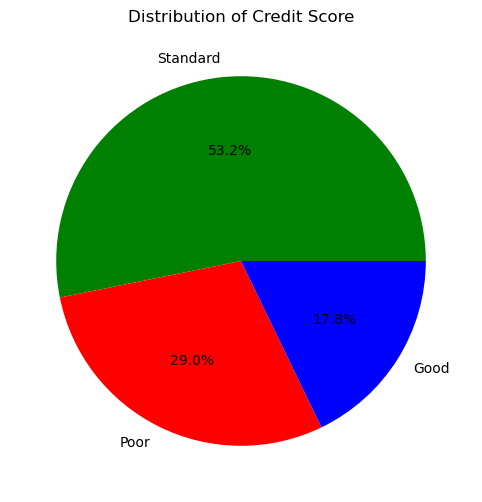

In [36]:
credit_score_count = df.groupBy('Credit_Score').count().collect()

# Sort the data by count in descending order
credit_score_count.sort(key=lambda x: x['count'], reverse=True)

categories = [row['Credit_Score'] for row in credit_score_count]
values = [row['count'] for row in credit_score_count]

colors = [palette.get(cat, 'gray') for cat in categories]

plt.figure(figsize=(10, 6))
plt.pie(values, labels=categories, autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Credit Score')
plt.show()

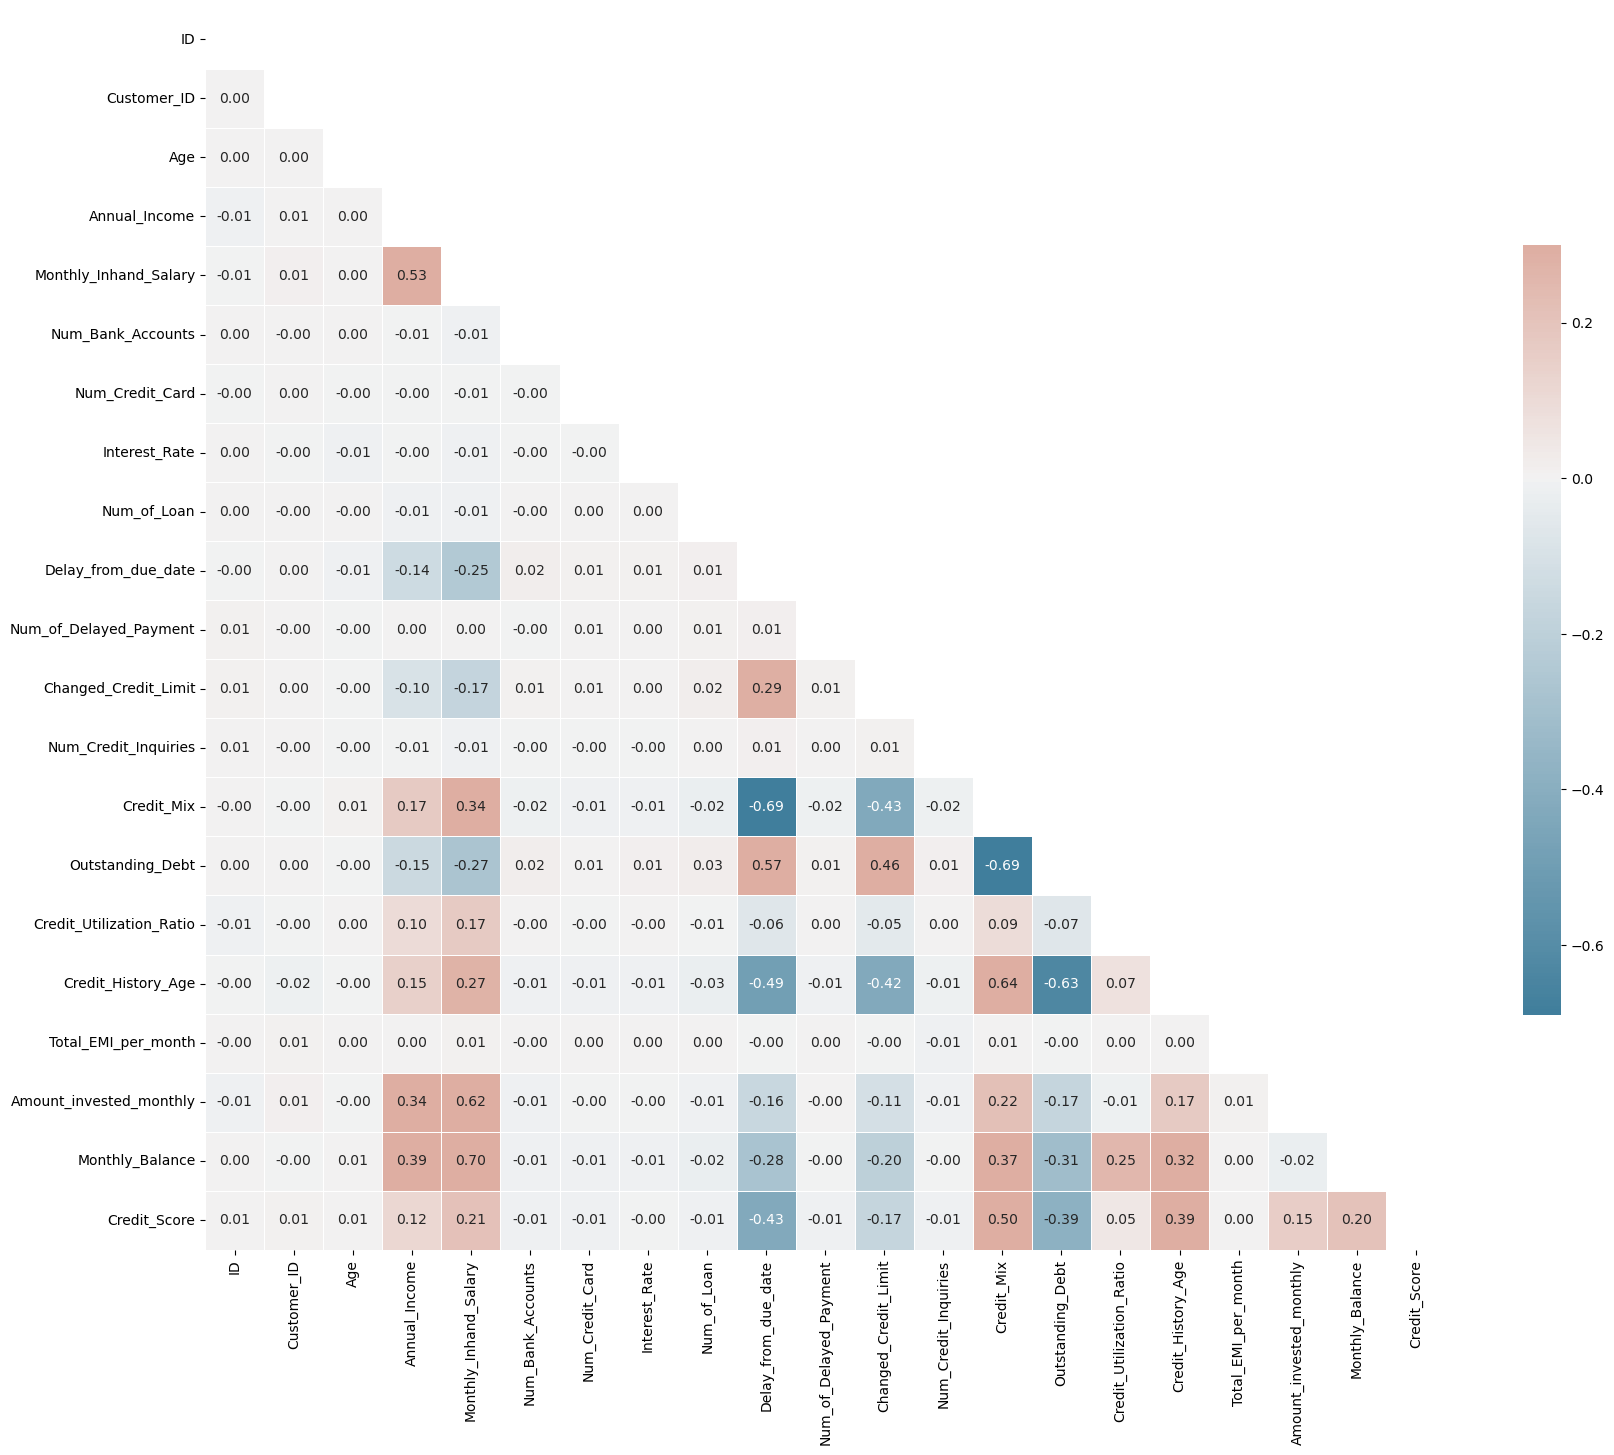

In [37]:
# Modify the Credit_Score & Credit_Mix column to int
df_plot = df.withColumn("Credit_Score",
                        F.when(col("Credit_Score") == "Poor", 0)
                        .when(col("Credit_Score") == "Standard", 1)
                        .when(col("Credit_Score") == "Good", 2)
                        .otherwise(col("Credit_Score").cast("int"))
                       )

df_plot = df_plot.withColumn("Credit_Mix",
                        F.when(col("Credit_Mix") == "Bad", 0)
                        .when(col("Credit_Mix") == "Standard", 1)
                        .when(col("Credit_Mix") == "Good", 2)
                        .otherwise(col("Credit_Mix").cast("int"))
                       )

# Calculate correlation for numeric columns
numeric_columns = [col for col, dtype in df_plot.dtypes if dtype != 'string']
corr_matrix = df_plot.select(numeric_columns).toPandas().corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(20, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt=".2f")

plt.show()

### Credit History Age

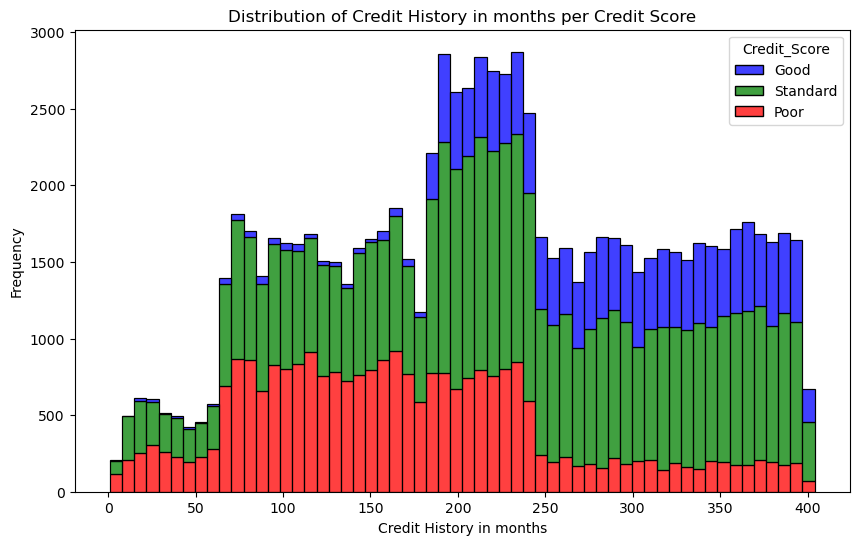

In [54]:
# Reorder the 'Credit_Score' column based on the desired order
_df['Credit_Score'] = _df['Credit_Score'].astype('category')
category_order = ["Good", "Standard", "Poor"]
_df['Credit_Score'] = _df['Credit_Score'].cat.reorder_categories(category_order, ordered=True)

# Create the histogram with the reordered 'Credit_Score' classification using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=_df, x="Credit_History_Age", hue="Credit_Score", multiple="stack", palette=palette)
plt.xlabel('Credit History in months')
plt.ylabel('Frequency')
plt.title('Distribution of Credit History in months per Credit Score')
plt.show()

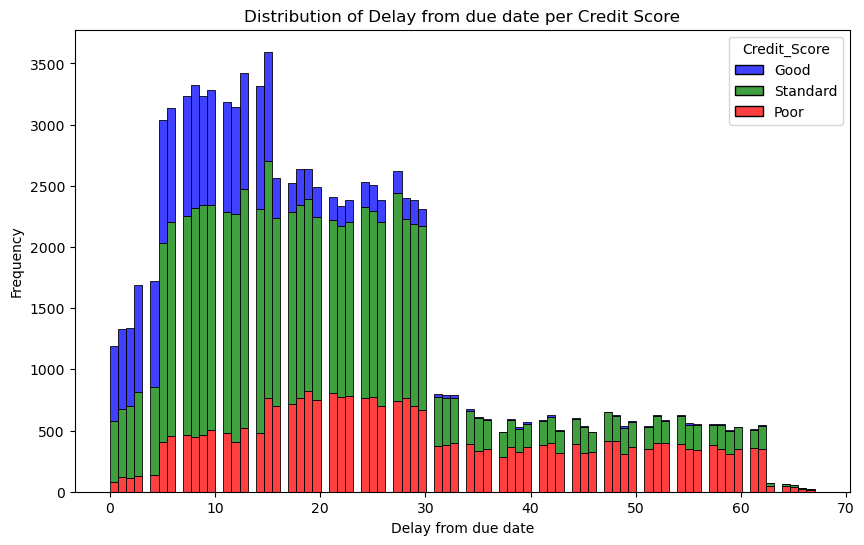

In [39]:
# Create a histogram with Credit_Score classification
plt.figure(figsize=(10, 6))
sns.histplot(data=_df, x="Delay_from_due_date", hue="Credit_Score", multiple="stack", palette=palette)
plt.xlabel('Delay from due date')
plt.ylabel('Frequency')
plt.title('Distribution of Delay from due date per Credit Score')
plt.show()

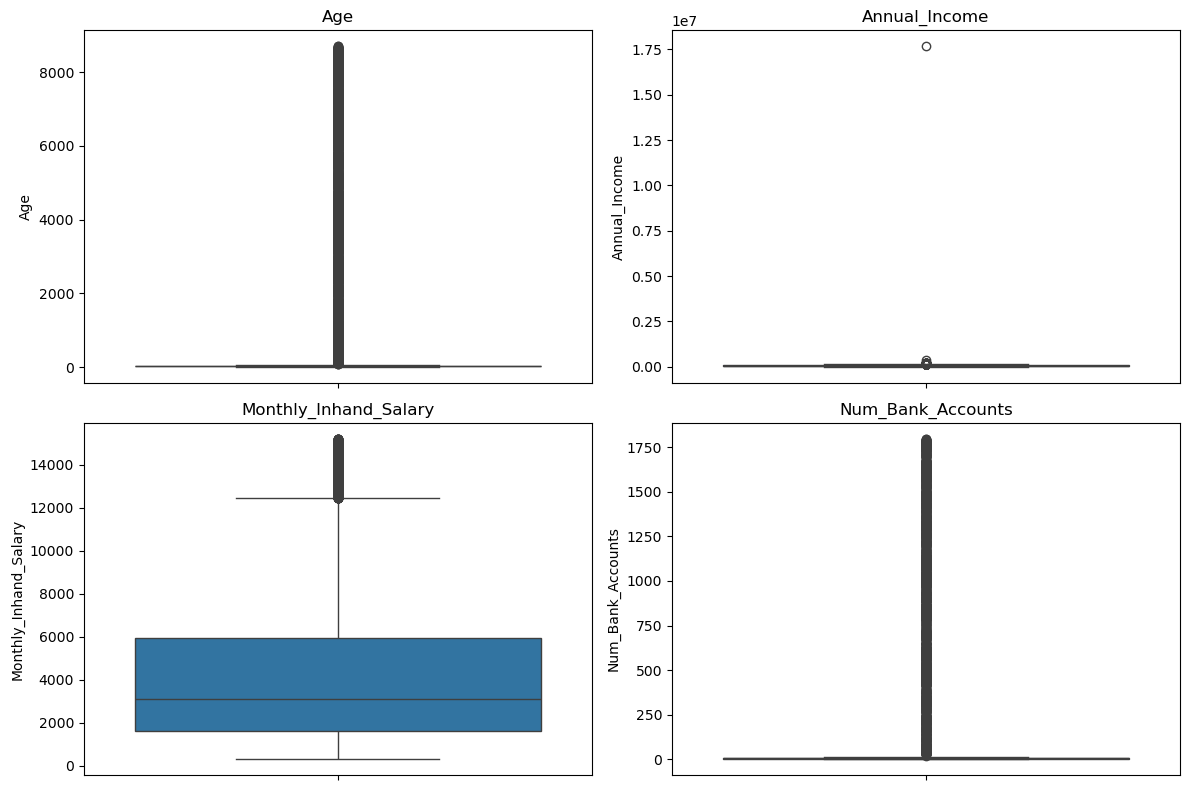

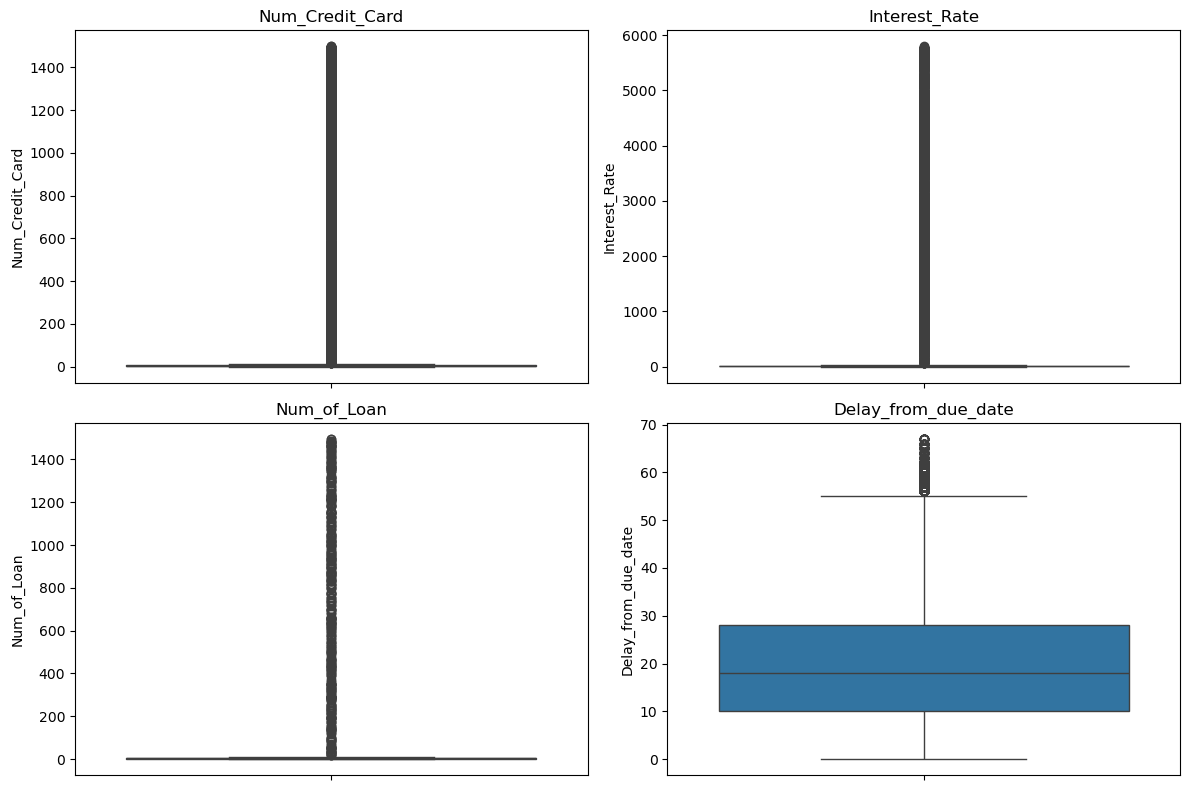

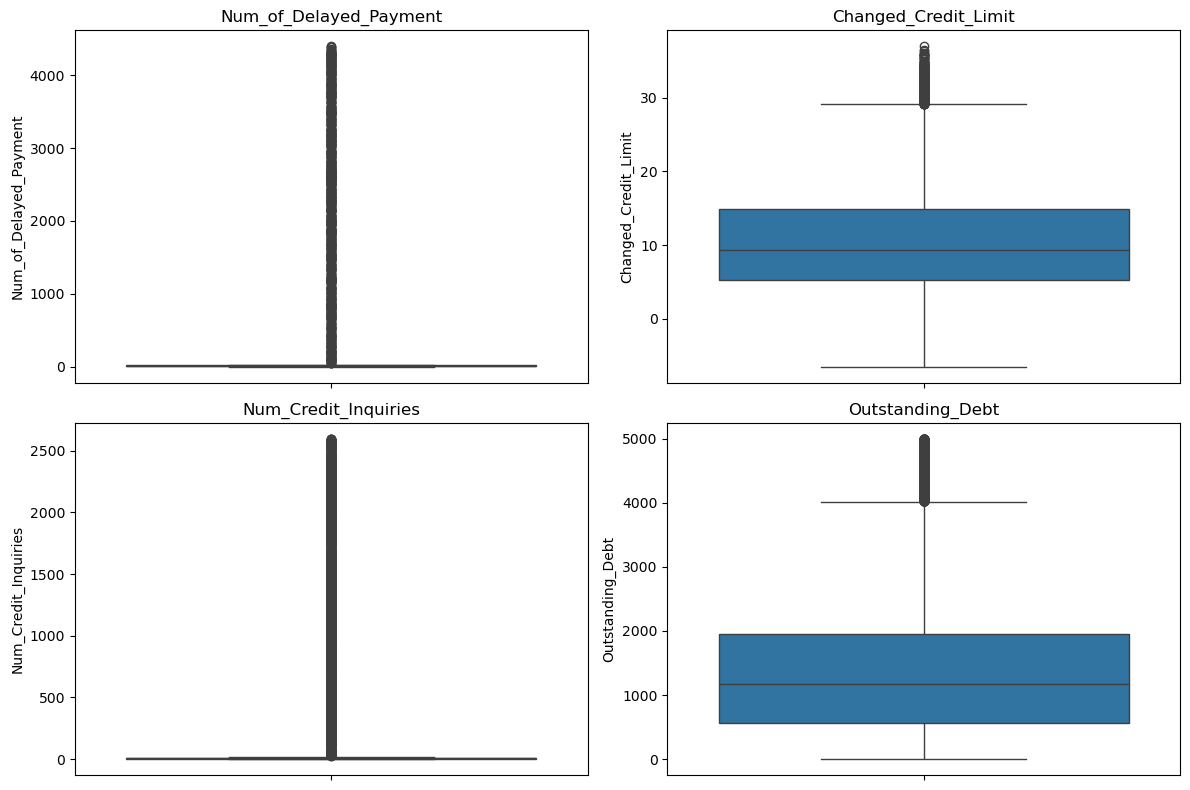

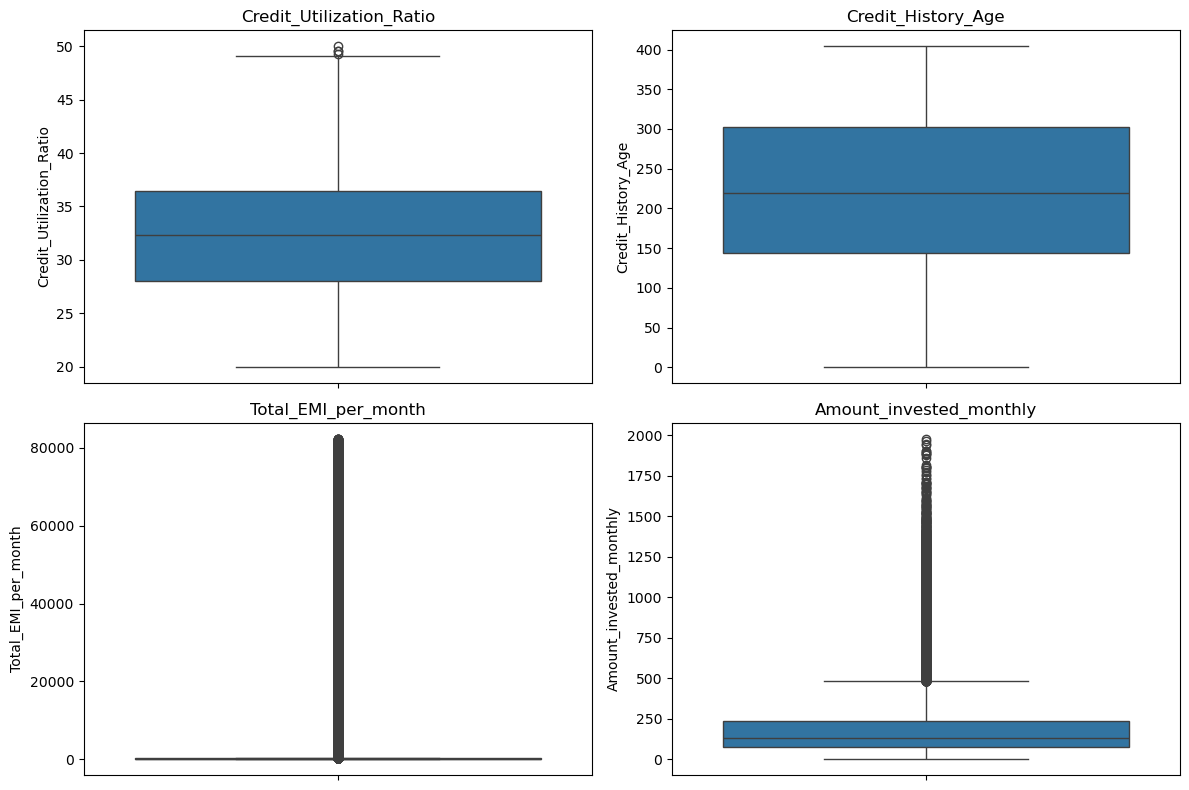

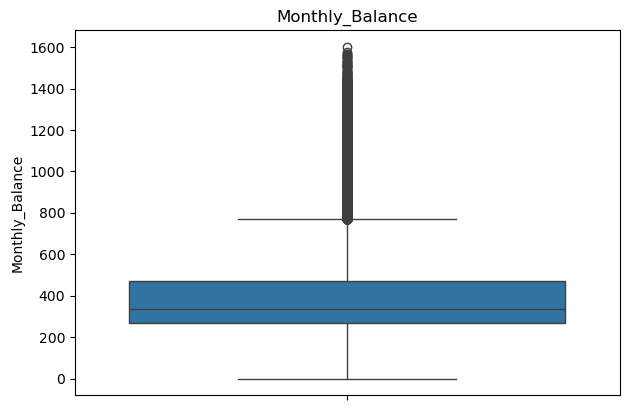

### Number of loans

In [41]:
result = df.groupBy('Occupation').agg(F.round(F.avg('Annual_Income'), 2).alias('Avg_Annual_Income'), F.round(F.avg('Num_of_Loan'), 2).alias('Avg_Num_of_Loan') )
result.show()

+-------------+-----------------+---------------+
|   Occupation|Avg_Annual_Income|Avg_Num_of_Loan|
+-------------+-----------------+---------------+
|    Scientist|          51207.0|           7.22|
|Media_Manager|         53326.39|            6.0|
|     Musician|         51384.18|           8.57|
|       Lawyer|         49594.22|           7.04|
|      Teacher|         49886.14|            7.7|
|    Developer|         50131.21|           6.45|
|       Writer|         51076.76|            5.8|
|    Architect|         51832.29|           6.87|
|     Mechanic|         50095.11|           8.09|
| Entrepreneur|          50987.7|           6.61|
|   Journalist|         48430.09|           7.06|
|       Doctor|         49573.63|           6.78|
|     Engineer|         50885.29|           8.26|
|   Accountant|         50750.93|           7.17|
|      Manager|         51469.22|           7.51|
|             |         37181.45|           3.01|
+-------------+-----------------+---------------+


In [ ]:
spark.stop()